In [2]:
import numpy as np
from numpy.linalg import inv, multi_dot
from numpy import matmul, exp, transpose
import pandas as pd
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [3]:
# Data: https://www.ecdc.europa.eu/en/publications-data/data-daily-new-cases-covid-19-eueea-country

In [4]:
class timeSeries():
    def __init__(self, df: pd.DataFrame, country: str, start: str, end: str):
        """
        Constructor
        Args:
            df (obj): The given dataset
            country (str): specifies the country we are interested in
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd 
        """
        self.country = country
        df.loc[:,'dateRep'] = pd.to_datetime(df.dateRep, format='%d/%m/%Y')
        self.start = start
        self.end = end
        self.rawData = df
        self.processedData = self.extract_country_and_time(start, end)

    def extract_country_and_time(self, start_str: str, end_str: str) -> pd.DataFrame:
        """
        Extracts the country and time frame from the given data set 
        Args:
            start (str): yyyy-mm-dd
            end (str): yyyy-mm-dd
        Returns the processed data set
        """
        
        df = self.rawData.copy(deep = False)

        # Extract the given country's data
        df = df[df.countriesAndTerritories == self.country]

        # Dropping unnecessary columns
        df = df[["dateRep", "day", "month", "year", "cases"]]
        df = df.sort_values(["year", "month","day"]) 
    
        # Set dates as index
        df = df.set_index('dateRep')

        # Filling missing data points with nan values
        idx = pd.date_range(df.index[0], df.index[-1])
        df = df.reindex(idx, fill_value=np.nan)

        # Linear interpolation of nan values
        df.loc[:,"cases"] = df.loc[:,"cases"].interpolate(method="linear")

        # Adding two features:
        # - total cumulative number of infected people
        # - current number of infected people (mean infection period = 14 days)
        df.loc[:,"cumCases"] = df.loc[:,"cases"].cumsum(axis=0)
        df.loc[:,"I"] = df.loc[:,"cases"].rolling(window=14).sum()

        # Extracting the give time frame

        try:
            start = pd.to_datetime(start_str)
            df = df.loc[start:]
        except:
            if (start_str != "start"):
                print("Wrong input")

        try:
            end = pd.to_datetime(end_str)
            df = df.loc[:end]
        except:
            if (end_str != "end"):
                print("Wrong input")

        # Add variable t for later computations
        df.loc[:,"t"] = list(range(len(df)))
                
        return df

    def linear_regression(self):
        """
        Returns an estimation of
        - beta (infection parameter)
        - I0 (initial value of infected people)
        for the given time frame and country
        """

        # Formatting
        df = self.processedData.loc[:,("t","cumCases")].set_index("t").copy(deep=False)
        t = np.array(df.loc[1:].index,dtype=np.float64).reshape(-1, 1)
        I = np.array(df.loc[1:, "cumCases"],dtype=np.float64).reshape(-1, 1)

        # Lin-Log regression
        X = np.concatenate((t,np.ones((len(t),1))),axis=1)
        XT = X.transpose()
        y = np.log(I)
        beta_hat = np.double(multi_dot([inv(matmul(XT, X)),XT,y])).round(4)
        I_0 = exp(beta_hat[1]).round(2)
        prediction = I_0 * exp(beta_hat[0] * t)
        
        # Visualization
        _, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)
        ax.set_title(f"{self.start} bis {self.end}", fontsize = 22)
        ax.plot(df.loc[1:].index,prediction, label="LAP", color="red",)
        ax.plot(df.loc[1:].index,df.cumCases[1:], label="Echte Daten", color="blue",marker=".", ls='none')
        ax.text(0.4, 0.85, f"$\hat \\beta = {beta_hat[0][0]}, \hat I_0 = {np.float64(I_0)}$", transform=ax.transAxes, fontsize=20)
        plt.rc('legend',fontsize=16)
        ax.legend()
        plt.show() 

        return beta_hat.reshape(2,)
    
    def nonlinear_regression(self):
        """
        Should calculate the parameters beta and I0 using a Newton's method.
        Unfortunately, for two main reasons this method does always work: 
        - Depending on the specific data set, the matrix F'(xk)^T*F'(xk) is sometimes singular
        - Due to the exponential function, values of the error function are often way too large
          to be handled by the computer
        """
        df = self.processedData
        t = np.array(df.loc[df["t"] > 0, "t"],dtype=np.float64).reshape(-1, 1)
        I = np.array(df.loc[df["t"] > 0, "cumCases"],dtype=np.float64).reshape(-1, 1)

        # Newton's Method
        def G(b):
            b0 = b[0]
            b1 = b[1]
            return np.log(matmul(transpose(I - b1*exp(b0*t)), I - b1*exp(b0*t)))

        # G'(x)
        def dGdb(b):
            b0 = b[0]
            b1 = b[1]
            Gb = G(b)
            dGdb0 = 1/(Gb) * 2*b1 * np.matmul(transpose(b1 * exp(b0*t)-I),t * exp(b1 * t))
            dGdb1 = 1/(Gb)*2* matmul(transpose(b1 * exp(b0*t)-I),exp(b0*t))
            return np.array([dGdb0, dGdb1]).reshape(2,)

        beta_hat = self.linear_regression()
        #beta_hat = np.array([0.2,1.0])
        beta_star = minimize(G, x0=beta_hat, method="Newton-CG", jac=dGdb).x.round(4)
        prediction = beta_star[1] * exp(beta_star[0] * t)
        

        _, ax = plt.subplots(figsize = (8,5))
        ax.margins(0.05)

        ax.set_title(f"{self.start} bis {self.end}, $I_0 = {beta_star[1]}$", fontsize = 22)
        ax.plot(df.t[1:],prediction, label="Newton-Meth.", color="red",)
        ax.plot(df.t[1:],df.cumCases[1:], label="Fallzahlen", color="blue",marker=".",ls='none')
        ax.text(0.45, 0.8, f"$ \\beta^* = $ {(beta_star[0],beta_star[1])}", transform=ax.transAxes, fontsize=18)
        plt.rc('legend',fontsize=16)

        ax.legend()
        plt.show()
        return beta_star
        

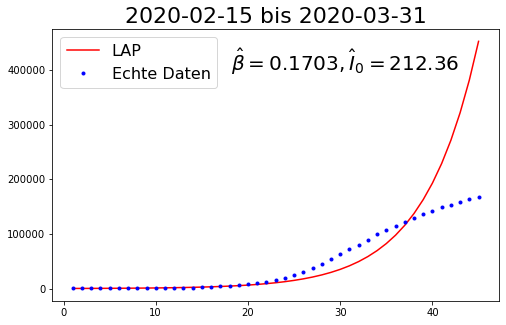

array([0.1703, 5.3583])

In [5]:
df = pd.read_csv("../data/europe_timeseries.csv")
ts1 = timeSeries(df, "Spain", "2020-02-15", "2020-03-31")
ts1.linear_regression()

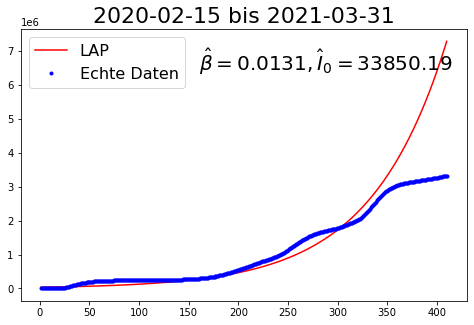

array([ 0.0131, 10.4297])

In [6]:
ts2 = timeSeries(df, "Spain", "2020-02-15", "2021-03-31")
ts2.linear_regression()